## Import Libraries

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

## Let's import data from google drive

### You can find the zip file in [link](https://drive.google.com/file/d/1kCosTCBz4ArgNQS2hnq1zASCFFccW00V/view?usp=share_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/kaggle/working/task_2.zip'
!cp '{file_path}' .

## Let's unzip task_2.zip file

In [29]:
!unzip -q task_2.zip
!rm task_2.zip -rf
!unzip -q train.zip
!rm train.zip -rf
!unzip -q test.zip
!rm test.zip -rf
!mv content/test .
!rm content -rf

# now we should have test and train folder, with lots of images

After above code your directory structure should be like this:
```bash
/
├── fingerprint_recognition.ipynb
├── test/
│   ├── image_1.jpg
│   ├── image_2.jpg
│   ├── ...
│   └── image_n.jpg
└── train/
    ├── image_1.jpg
    ├── image_2.jpg
    ├── ...
    └── image_n.jpg
```

## Distribute images according to their labels to different files

Needed for ImageDataGenerator.flow_from_directory()

In [32]:
import shutil

def import_files(dir='train'):
  if dir != 'train' and dir != 'test':
    print('W:import_files(dir): dir should be either train or test')
    return

  root = 'data'
  if not os.path.exists(root):
    os.makedirs(root)
  new_train = f'data/{dir}'
  for filename in os.listdir(dir):
    id, target = filename.split('_')
    target = int(target.split('.')[0])

    dir_path = f'{new_train}/{target}'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)

    bmp = filename.endswith('.bmp')
    src_file = f'{dir}/{filename}'
    dest_file = f'{dir_path}/{filename}' + ('' if bmp else '.bmp')

    shutil.copy(src_file, dest_file)


### Import train and test files

In [33]:
import_files('train')
import_files('test')

After distribution you should have directory structure like this:
```bash
/
├── fingerprint_recognition.ipynb
└── data/
    ├── train/
    │   ├── 0/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 1/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 2/
    │   ├── ...
    │   └── 9/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    ├── test/
    │   ├── 0/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 1/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 2/
    │   ├── ...
    │   └── 9/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    └── ...
```

## Let see if we have balanced dataset

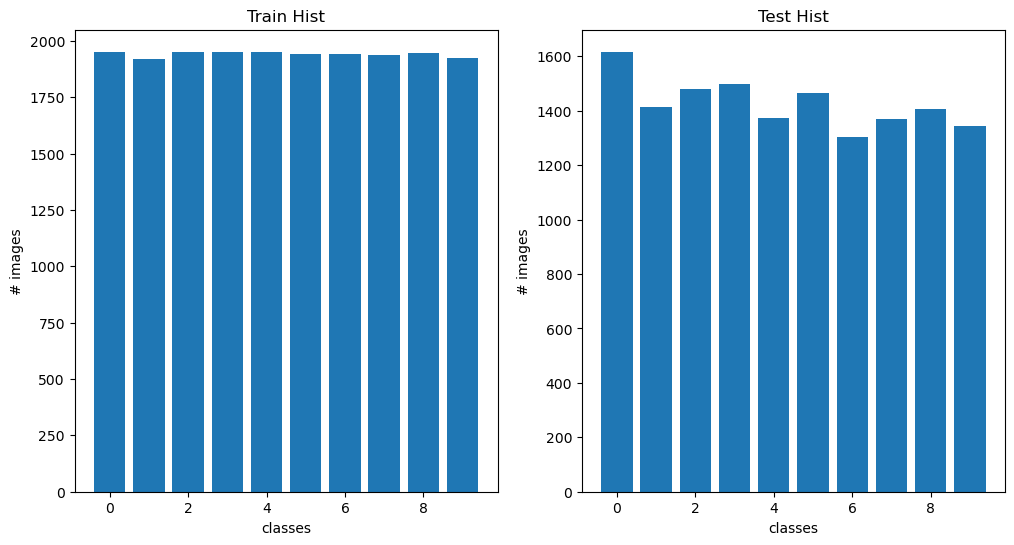

In [34]:
def plot_hist_classes(dir):

  n_samples = np.zeros(10)
  for class_dir in os.listdir(dir):
    if not os.path.isdir(os.path.join(dir, class_dir)):
      print('E:plot_hist_classes(dir): expected to find in `dir` only directories')
      return
    num_files = len([f for f in os.listdir(os.path.join(dir, class_dir))])

    n_samples[int(class_dir)] = num_files

  plt.bar(range(len(n_samples)), n_samples)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Hist')
plt.xlabel('classes')
plt.ylabel('# images')
plot_hist_classes('data/train')

plt.subplot(1, 2, 2)
plt.title('Test Hist')
plt.xlabel('classes')
plt.ylabel('# images')
plot_hist_classes('data/test')
plt.show()

### Okay, our dataset is more or less balanced, which is good

## Create ImageDataGenerator

In [35]:
# remove frame around each image
# it will be very usefull after applying rotation
# it replace frame by white color
def remove_frame(img):
  img[:5, :, :] = 255
  img[:, :5, :] = 255
  img[-5:, :, :] = 255
  img[:, -5:, :] = 255
  return img

class MyImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def apply_transform(self, x, transform_parameters):
        x = remove_frame(x)
        x = super().apply_transform(x, transform_parameters)
        return x

train_gen = MyImageDataGenerator(
    # data augmentation
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='constant',
    cval=255, # white

    # data preprocessing
    rescale=1./255,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    preprocessing_function=remove_frame,
    rescale=1./255,
)

## Create train and test Datasets

In [36]:
batch_size = 32
img_size = (90, 90)

train_dir = 'data/train'
train_dataset = train_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=img_size,
    subset='training',
    keep_aspect_ratio=True,
)

val_dataset = train_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=img_size,
    subset='validation',
    keep_aspect_ratio=True,
)

test_dir = 'data/test'
test_dataset = test_gen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    target_size=img_size,
    keep_aspect_ratio=True,
)

classes = 10

Found 15533 images belonging to 10 classes.
Found 3880 images belonging to 10 classes.
Found 14272 images belonging to 10 classes.


## Lets look at some samples

### Test Data

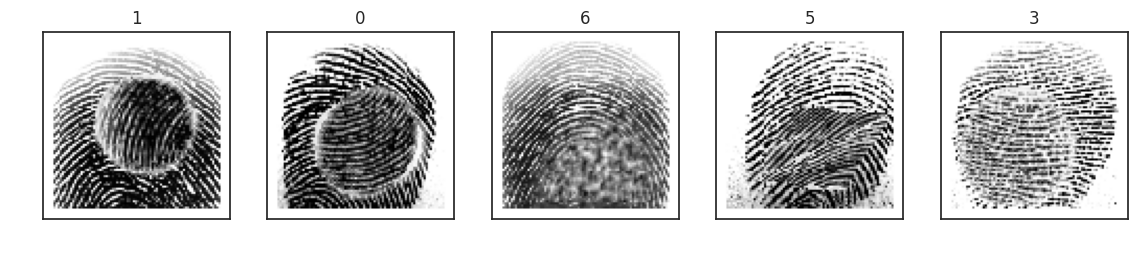

In [ ]:
n_images = 5
plt.figure(figsize=(14, 8))
for i in range(n_images):
  plt.subplot(1, n_images, i + 1)
  plt.title(test_dataset.next()[1][0].argmax())
  plt.xticks(color='w')
  plt.yticks(color='w')
  plt.imshow(test_dataset.next()[0][0])

plt.show()

### Augmented Data

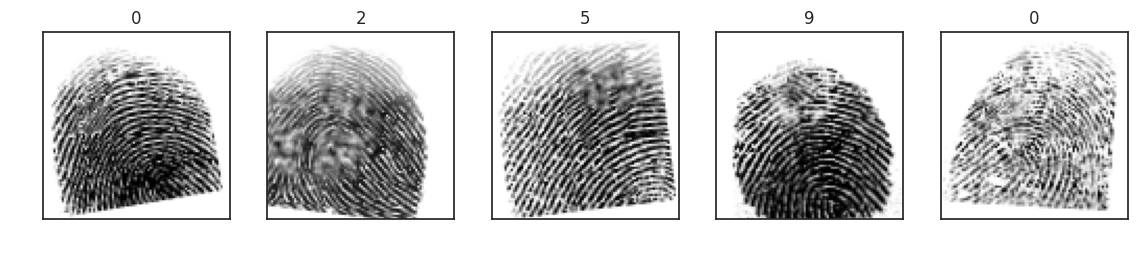

In [ ]:
n_images = 5
plt.figure(figsize=(14, 8))
for i in range(n_images):
  plt.subplot(1, n_images, i + 1)
  plt.title(train_dataset.next()[1][0].argmax())
  plt.xticks(color='w')
  plt.yticks(color='w')
  plt.imshow(train_dataset.next()[0][0])

plt.show()

## Define the model architecture

[This](https://arxiv.org/pdf/1409.1556.pdf) research paper provides good architerture for IMAGE RECOGNITION.



In [37]:
model = keras.Sequential([
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  
  layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2, 2) ,strides=(2, 2)),

  layers.Conv2D(254, kernel_size=(3, 3), activation='relu'),
  layers.Conv2D(254, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(classes, activation='softmax'),
])

In [38]:
model.build((None, img_size[0], img_size[1], 3))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 254)       292862    
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 254)       5

## Compile the model

In [43]:
learning_rate = 0.001
epochs = 1024

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.004)
loss = keras.losses.categorical_crossentropy
metrics=['accuracy']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

## Create Callbacks


In [44]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "vgg.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto'
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.9,
    patience=3,
)

## Fit the model

In [45]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=[checkpoint, early, lr_scheduler],
    use_multiprocessing=True,
    workers=2,
)

Epoch 1/1024
485/486 [============================>.] - ETA: 0s - loss: 1.9536 - accuracy: 0.2683
Epoch 1: val_loss improved from inf to 1.61596, saving model to vgg.h5
486/486 [==============================] - 59s 101ms/step - loss: 1.9532 - accuracy: 0.2683 - val_loss: 1.6160 - val_accuracy: 0.3838 - lr: 0.0010
Epoch 2/1024
485/486 [============================>.] - ETA: 0s - loss: 1.5577 - accuracy: 0.4165
Epoch 2: val_loss improved from 1.61596 to 1.38440, saving model to vgg.h5
486/486 [==============================] - 48s 99ms/step - loss: 1.5578 - accuracy: 0.4166 - val_loss: 1.3844 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 3/1024
486/486 [==============================] - ETA: 0s - loss: 1.4015 - accuracy: 0.4813
Epoch 3: val_loss did not improve from 1.38440
486/486 [==============================] - 47s 97ms/step - loss: 1.4015 - accuracy: 0.4813 - val_loss: 1.3860 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 4/1024
486/486 [==============================] - ETA: 0s - loss: 1.

## Let's visualize the results

### Plot loss

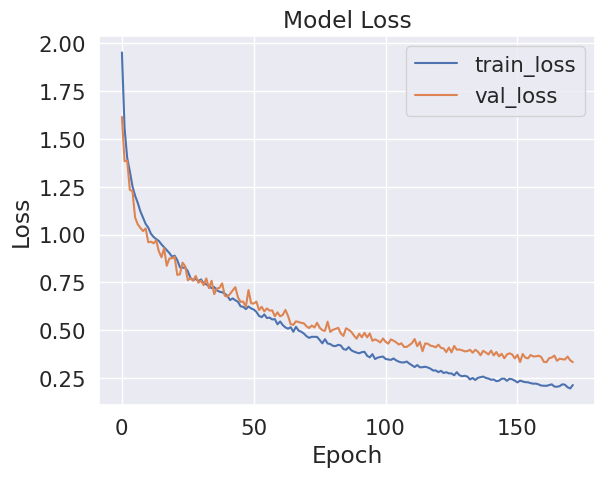

In [47]:
sns.set(style="darkgrid", font_scale=1.4)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Plot accuracy

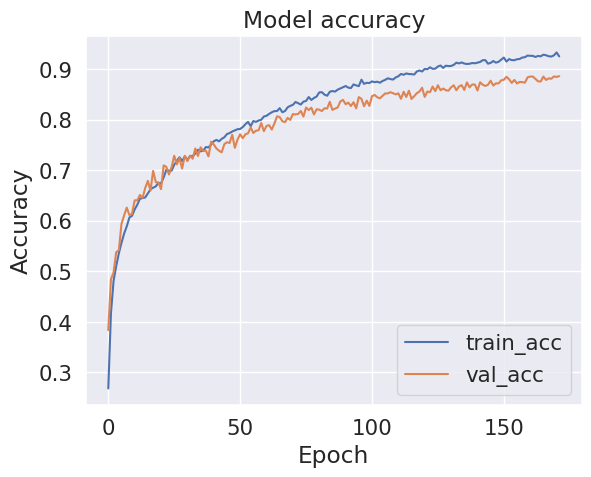

In [56]:
plt.plot(history.history["accuracy"], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Evaluate Test dataset

In [57]:
model.evaluate(
    test_dataset,
    batch_size=batch_size,
    use_multiprocessing=True,
    workers=2,
)

446/446 [==============================] - 11s 25ms/step - loss: 1.0249 - accuracy: 0.7845


[1.024908423423767, 0.7845431566238403]